In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Project/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: IDC/validation/1/12817_idx5_x401_y701_class1.png  
  inflating: IDC/validation/1/12817_idx5_x401_y851_class1.png  
  inflating: IDC/validation/1/12817_idx5_x601_y601_class1.png  
  inflating: IDC/validation/1/12817_idx5_x651_y551_class1.png  
  inflating: IDC/validation/1/12817_idx5_x651_y701_class1.png  
  inflating: IDC/validation/1/12817_idx5_x701_y451_class1.png  
  inflating: IDC/validation/1/12817_idx5_x751_y551_class1.png  
  inflating: IDC/validation/1/12817_idx5_x751_y851_class1.png  
  inflating: IDC/validation/1/12817_idx5_x851_y351_class1.png  
  inflating: IDC/validation/1/12817_idx5_x951_y651_class1.png  
  inflating: IDC/validation/1/12818_idx5_x1551_y1001_class1.png  
  inflating: IDC/validation/1/12818_idx5_x1551_y1651_class1.png  
  inflating: IDC/validation/1/12818_idx5_x1551_y1801_class1.png  
  inflating: IDC/validation/1/12818_idx5_x1601_y1401_class1.png  
  inflating: IDC/validation/1/12818_idx5_x160

In [3]:
import random
import cv2
import os
import glob
from tqdm import tqdm
import numpy as nump
import seaborn as sea_brn
import tensorflow as tnsr
import matplotlib.pyplot as mplot

from PIL import Image, ImageEnhance
from skimage.io import imread, imshow
from tensorflow.keras.utils import to_categorical, plot_model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

In [4]:
dataset=glob.glob("/content/IDC/*/*/*")

In [5]:

len(dataset)

277524

In [6]:

random.shuffle(dataset)
dataset

['/content/IDC/training/1/15510_idx5_x2601_y1551_class1.png',
 '/content/IDC/training/0/12955_idx5_x701_y651_class0.png',
 '/content/IDC/training/1/14213_idx5_x1801_y1401_class1.png',
 '/content/IDC/training/0/12749_idx5_x2151_y601_class0.png',
 '/content/IDC/training/0/13687_idx5_x351_y951_class0.png',
 '/content/IDC/training/1/12911_idx5_x1651_y1501_class1.png',
 '/content/IDC/validation/1/9126_idx5_x1851_y2001_class1.png',
 '/content/IDC/testing/0/16085_idx5_x2451_y1301_class0.png',
 '/content/IDC/training/0/9321_idx5_x2001_y1601_class0.png',
 '/content/IDC/training/0/10261_idx5_x601_y1051_class0.png',
 '/content/IDC/validation/0/10254_idx5_x251_y1401_class0.png',
 '/content/IDC/training/1/14155_idx5_x2451_y1801_class1.png',
 '/content/IDC/training/1/13022_idx5_x2351_y1551_class1.png',
 '/content/IDC/testing/0/10293_idx5_x2201_y1151_class0.png',
 '/content/IDC/training/0/8918_idx5_x601_y551_class0.png',
 '/content/IDC/testing/0/16532_idx5_x2251_y751_class0.png',
 '/content/IDC/train

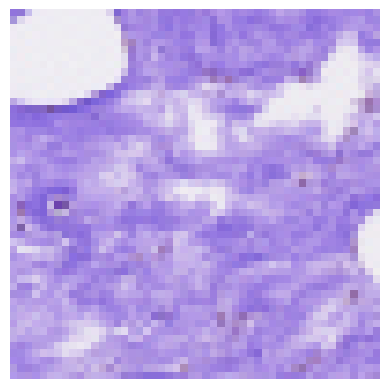

In [7]:

img=cv2.imread(dataset[1])

mplot.imshow(img)

mplot.axis('off')

mplot.show()

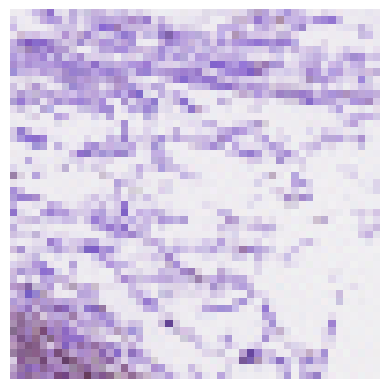

In [8]:

img=cv2.imread(dataset[12])

mplot.imshow(img)

mplot.axis('off')

mplot.show()

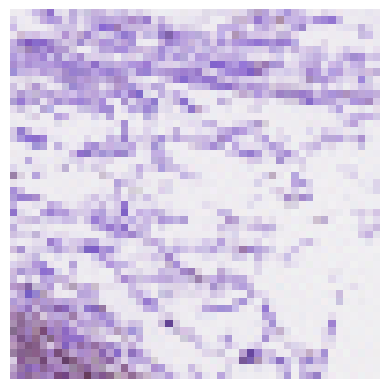

In [9]:
img_resize=cv2.resize(img,(50,50))
mplot.imshow(img_resize)
mplot.axis('off')
mplot.show()

In [ ]:
#PREPROCESSING THE DATA
data = []
labels = []
for image_path in tqdm(dataset):
    img = cv2.imread(image_path)
    R_G_B = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    pil_image = Image.fromarray(R_G_B)
    # I have enhance the sharpness of the image
    sharpness = ImageEnhance.Sharpness(pil_image)
    sharp_image = sharpness.enhance(2.0)
    # I have enhance the contrast of the image
    contrast = ImageEnhance.Contrast(sharp_image)
    # I have enhance the color of the image
    contrast_image = contrast.enhance(2.0)
    color = ImageEnhance.Color(contrast_image)
    color_image = color.enhance(1.5)
    img_re = cv2.resize(R_G_B, (50, 50))
    # I have used the Context-limited adaptive histogram equalisation (CLAHE)
    lab_image = cv2.cvtColor(img_re, cv2.COLOR_RGB2LAB)
    Lab_plns = list(cv2.split(lab_image))
    clh_ = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
    Lab_plns[0] = clh_.apply(Lab_plns[0])
    lab_image = cv2.merge(tuple(Lab_plns))
    clh__image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    data.append(clh__image)
    label = image_path.split(os.path.sep)[-2]
    if label == "0":
        label = 0
    elif label == "1":
        label = 1
    labels.append(label)

 35%|███▍      | 96617/277524 [01:34<02:48, 1072.72it/s]

In [ ]:
# Used mplot to plot the images
mplot.figure(figsize=(13,7))
for i in range(20):
    mplot.subplot(4,5,i+1)
    mplot.imshow(data[i],cmap ='gray')
    mplot.title(labels[i])
    mplot.axis("off")

In [ ]:
# Converting data and labels into the numpy array
da_ta = nump.array(data)
lbls = nump.array(labels)
da_ta.shape,lbls.shape

In [ ]:
# Data balancing using SMOTE
data_shp = da_ta.shape[1]*da_ta.shape[2]*da_ta.shape[3]
da_ta = da_ta.reshape(da_ta.shape[0], data_shp)
smt = SMOTE()
da_ta, lbls  = smt.fit_resample(da_ta, lbls)
for i in range(len(da_ta)):
    da_ta = da_ta.reshape(len(da_ta), 50, 50, 3)

In [ ]:
#Spliting the data into testing and training
 (_X__Trn_, _X__Tt_, _y__Trn_, _y__Tt_) = train_test_split(da_ta, lbls,test_size=0.2, random_state=44)

In [ ]:
cat__yTrn_ = to_categorical(_y__Trn_)
cat__yTt_ = to_categorical(_y__Tt_)

In [ ]:
import tensorflow as tf

#EfficientNetB7 Model

In [ ]:
#I have Implemented the instance of EfficientB7 model
mdl = EfficientNetB7(weights='imagenet', pooling=max, include_top = False,input_shape=(50,50,3))

In [ ]:

NUM_CLASSES = 2

model = Sequential()

model.add(mdl)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(Dense(512, activation='relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))
model.layers[0].trainable = True
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
tnsr.keras.utils.plot_model(model, to_file='proposed_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(_X__Trn_, cat__yTrn_, epochs=10, batch_size=101, validation_data=(_X__Tt_, cat__yTt_))

In [ ]:
# Evaluted training accuracy
_, acc_train=model.evaluate(_X__Trn_, cat__yTrn_)

In [ ]:
# Evaluated testing accuracy
_, acc_test=model.evaluate(_X__Tt_, cat__yTt_)

In [ ]:
mplot.figure(figsize=(14,7))
mplot.plot(history.history['val_accuracy'], label="val accuracy")
mplot.title("Accuracy",fontsize=16)
mplot.xlabel("epochs",fontsize=16)
mplot.ylabel("accuracy",fontsize=16)
mplot.legend()
mplot.show()

In [ ]:
mplot.figure(figsize=(14,7))
mplot.plot(history.history['loss'], label="training loss")
mplot.plot(history.history['val_loss'], label="val loss")
mplot.title("Loss",fontsize=16)
mplot.xlabel("epochs",fontsize=16)
mplot.ylabel("Loss",fontsize=16)
mplot.legend()
mplot.show()

In [ ]:
#predictions on the test dataset
pred = model.predict(_X__Tt_)
# Convert true labels to one-hot encoded form
YTrue1 = nump.argmax(cat__yTt_,axis=1)
# Convert predicted labels to one-hot encoded form
YPred1 = nump.argmax(pred,axis=1)

In [ ]:
#predictions on the training dataset
pred1 = model.predict(_X__Trn_)
# Convert true labels to one-hot encoded form
YTrue2 = nump.argmax(cat__yTrn_,axis=1)
# Convert predicted labels to one-hot encoded form
YPred2 = nump.argmax(pred1,axis=1)

In [ ]:
sentiment_classes = ['0', '1']
# Create a heatmap of the confusion matrix
mplot.figure(figsize=(8,6))
sea_brn.heatmap(confusion_matrix(YTrue1, YPred1),
                cmap=mplot.cm.Blues,
                fmt='d',
                annot=True,
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
mplot.title('Confusion matrix for testing\n', fontsize=18)
mplot.xlabel('Actual label', fontsize=16)
mplot.ylabel('Predicted label', fontsize=16);

In [ ]:
print('Classification report for testing:\n')
print(classification_report(YTrue1, YPred1))

In [ ]:
# Print the sensitivity, specificity, error rate, and ROC-AUC score for testing
print('Sensitivity, Specificity, Error Rate and ROC-AUC Score:\n')
cf = confusion_matrix(YTrue1, YPred1)

# Compute sensitivity and specificity
sensitivity1 = cf[0, 0] / (cf[0, 0] + cf[0, 1])
print('Sensitivity for testing : ', sensitivity1)
specificity1 = cf[1, 1] / (cf[1, 0] + cf[1, 1])
print('Specificity for testing : {:.4f}'.format(specificity1))

# Compute the error rate
cm = confusion_matrix(YTrue1, YPred1)
error_rate = 1 - nump.trace(cm) / nump.sum(cm)
print('Error rate: {:.4f}'.format(error_rate))

# Define a function for scoring ROC-AUC score for binary classification
def binary_roc_auc_score(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc

y_test_binary = label_binarize(cat__yTt_[:,0], classes=[0, 1])

y_pred_binary = pred[:, 0]
roc_auc = binary_roc_auc_score(y_test_binary, y_pred_binary)
print('ROC AUC score of model:{:.4f}'.format(roc_auc))

In [ ]:
# Plot confusion matrix for training data
mplot.figure(figsize=(8,6))
sea_brn.heatmap(confusion_matrix(YTrue2, YPred2),cmap=mplot.cm.Blues,fmt ='d',annot=True,xticklabels=sentiment_classes,yticklabels=sentiment_classes)
mplot.title('Confusion matrix for training\n', fontsize=18)
mplot.xlabel('Actual label', fontsize=16)
mplot.ylabel('Predicted label', fontsize=16);

In [ ]:
print('Classification report for training:\n')
print(classification_report(YTrue2, YPred2))

In [ ]:
# Calculate sensitivity and specificity for training data
print('Sensitivity and Specificity:\n')
cf=confusion_matrix(YTrue2 , YPred2)
sensitivity2 = cf[0,0]/(cf[0,0]+cf[0,1])
print('Sensitivity for training : ', sensitivity2 )
specificity2 = cf[1,1]/(cf[1,0]+cf[1,1])
print('Specificity for training : ', specificity2)

In [ ]:
#Receviver Operating Charactertics and Area under the curve ROC-AUC
def binary_roc_auc_score(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc

y_test_binary = label_binarize(cat__yTt_[:,0], classes=[0, 1])

y_pred_binary = pred[:,0]

roc_auc = binary_roc_auc_score(y_test_binary, y_pred_binary)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_binary)

# Plot the ROC curve
mplot.figure(figsize=(8, 6))
mplot.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(roc_auc))
mplot.plot([0, 1], [0, 1], 'k--', label='Random guess')
mplot.xlim([0.0, 1.0])
mplot.ylim([0.0, 1.05])
mplot.xlabel('False Positive Rate',fontsize=16)
mplot.ylabel('True Positive Rate',fontsize=16)
mplot.title('Receiver Operating Characteristic (ROC) Curve',fontsize=16)
mplot.legend(loc="lower right")
mplot.show()